In [1]:

import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy import signal
from torch import nn

# 乱数固定用の処理
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


In [2]:
class BuckConverterCell(nn.Module):
    def __init__(
        self,
        dt: float = 1e-6,
        L_init: float = 200e-6,
        C_init: float = 100e-6,
        R_init: float = 8.0,
    ) -> None:
        super().__init__()
        self.dt = dt
        # パラメータを対数空間で学習（正の値を保証）
        self.log_L = nn.Parameter(torch.log(torch.tensor(L_init)))
        self.log_C = nn.Parameter(torch.log(torch.tensor(C_init)))
        self.log_R = nn.Parameter(torch.log(torch.tensor(R_init)))

    def forward(
        self, h: torch.Tensor, x: torch.Tensor
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """
        h: [batch, 2] - [i_L, v_C]
        x: [batch, 1] - [v_a]
        """
        i_L = h[:, 0]
        v_C = h[:, 1]
        v_a = x[:, 0].clone()

        # パラメータを指数関数で変換（正の値を保証）
        L = torch.exp(self.log_L)
        C = torch.exp(self.log_C)
        R = torch.exp(self.log_R)

        # --- DCM対応: 元のコードと同じロジック ---
        # スイッチOFF（va==0）かつ電流がゼロ以下の時、va = v_C（出力電圧）
        idx = (v_a == 0) & (i_L <= 0)
        v_a[idx] = v_C[idx]

        # 実効的なvaを保存（可視化用）
        v_a_eff = v_a.clone()
        # --------------------------------------------

        # オイラー法による状態更新（元のコードと同じ順序）
        # 1. インダクタ電流の更新
        i_L_next = i_L + (self.dt / L) * (v_a - v_C)
        i_L_next = torch.relu(i_L_next)  # 電流は負にならない（DCM考慮）

        # 2. コンデンサ電圧の更新（現在のi_Lを使用）
        v_C_next = v_C + (self.dt / C) * (i_L - v_C / R)

        return torch.stack([i_L_next, v_C_next], dim=1), v_a_eff

    def get_params(self) -> dict:
        return {
            "L": torch.exp(self.log_L).item(),
            "C": torch.exp(self.log_C).item(),
            "R": torch.exp(self.log_R).item(),
        }

# BuckConverterCell を使ってシミュレーションデータを作成


In [3]:
# 学習データ作成 (vp: 方形波)
Vin, Vref = 28, 6
Ts = 1 / 20e3  # スイッチング周期
dt = Ts / 100  # サンプリング周期 (1周期あたり100分割)

# 方形波
t_one_cycle = np.arange(0, Ts, dt)
s_pri = signal.square(2 * np.pi / Ts * t_one_cycle, duty=Vref / Vin)
vp_one_cycle = (s_pri > 0).astype(float) * Vin

# 200周期分繰り返す
repeat = 200
vp = np.tile(vp_one_cycle, repeat)
t = np.arange(0, len(vp)) * dt


In [4]:
# vpを入力としてシミュレーション
model = BuckConverterCell(dt=dt, L_init=10e-6, C_init=1000e-6, R_init=3)

va_list = []
il_list = []
vo_list = []

# シミュレーション実行
with torch.no_grad():
    h_current = torch.zeros(1, 2)  # [i_L=0, v_C=0]
    for i in range(len(vp)):
        va_input = torch.tensor([[vp[i]]], dtype=torch.float32)

        # 現在の状態を保存
        il_list.append(h_current[0, 0].item())  # i_L
        vo_list.append(h_current[0, 1].item())  # v_C (= v_o)

        # 次の状態と実効vaを計算
        h_current, va_eff = model(h_current, va_input)

        # 実効的なva（DCM対応済み）を保存
        va_list.append(va_eff[0].item())

va = np.array(va_list)
il = np.array(il_list)
vo = np.array(vo_list)


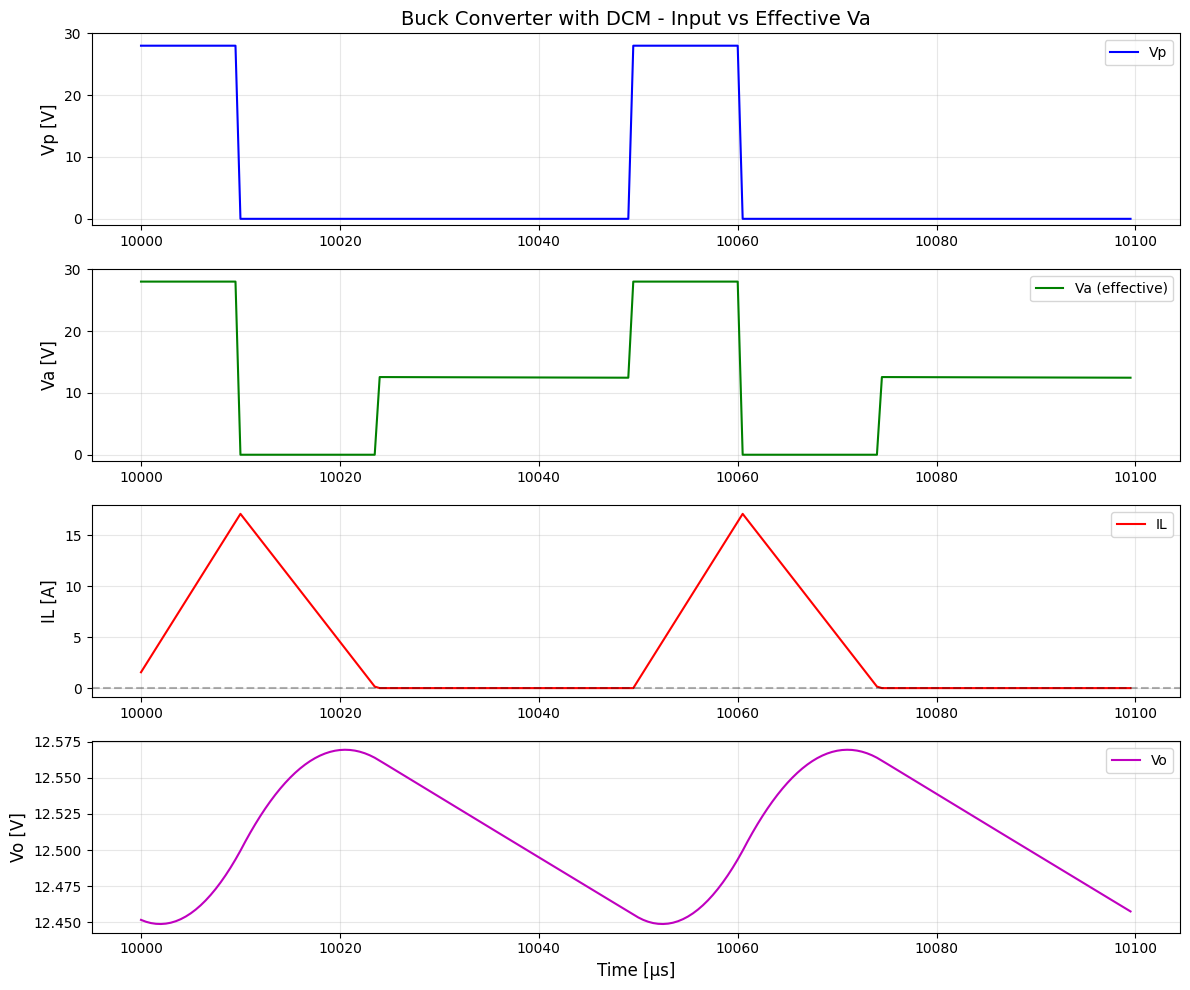

In [5]:
# プロット
plot_range = 200

fig, axes = plt.subplots(4, 1, figsize=(12, 10))

# vp (PWM入力)
axes[0].plot(t[-plot_range:] * 1e6, vp[-plot_range:], "b-", linewidth=1.5, label="Vp")
axes[0].set_ylabel("Vp [V]", fontsize=12)
axes[0].set_title("Buck Converter with DCM - Input vs Effective Va", fontsize=14)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(-1, Vin + 2)
axes[0].legend()

# va (実効電圧、DCM対応)
axes[1].plot(
    t[-plot_range:] * 1e6, va[-plot_range:], "g-", linewidth=1.5, label="Va (effective)"
)
axes[1].set_ylabel("Va [V]", fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(-1, Vin + 2)
axes[1].legend()

# il (インダクタ電流)
axes[2].plot(t[-plot_range:] * 1e6, il[-plot_range:], "r-", linewidth=1.5, label="IL")
axes[2].axhline(y=0, color="k", linestyle="--", alpha=0.3)
axes[2].set_ylabel("IL [A]", fontsize=12)
axes[2].grid(True, alpha=0.3)
axes[2].legend()

# vo (出力電圧)
axes[3].plot(t[-plot_range:] * 1e6, vo[-plot_range:], "m-", linewidth=1.5, label="Vo")
axes[3].set_ylabel("Vo [V]", fontsize=12)
axes[3].set_xlabel("Time [µs]", fontsize=12)
axes[3].grid(True, alpha=0.3)
axes[3].legend()

plt.tight_layout()
plt.show()


# 学習データを使って回路パラメータの推論
## 現状の主な問題点
1. エポックがかかりすぎる
   1. 先行研究では75だが、note3では3000くらいかかった
   2. 学習率を各回路パラメータごとに変える
      1. 先行研究では学習率を回路パラメータごとに変えている
      2. note3では全て同じ学習率でやった
      3. オーダーが違うのでそれにある程度合わせる
   3. 初期値の取り方
2. 学習データの種類が1パターンしかない
   1. 先行研究の方では2つの異なる学習データを使っている
3. 回路パラメータが負になってしまうパターンがあることがわかった
   1. 回路パラメータは本来、正の値しかありえないが、学習の過程で負の値になることがある
   2. 先行研究ではClamperと初期値を都合のいいように設定して負にならないようにしているが、初期値やclampの範囲をいじると負になることがあった
   3. note3ではlogとexpを使って正の値を保証している
      1. これはとりあえずおっけい
   4. 問題は、clampの範囲をどこまでどのように設定すれば正しく学習が進むかわからない
   5. おそらく極端なデータを学習させるとバグる